##  Amazon Fine Food Reviews Analysis

### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

### Attribute Information:
* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

### Objective:

* Find the right hyperparameter k(# of clusters)  for all bow, tf-idf, avg w2v, tf-idf w2v.
* Perform K-means Clustering, hierachical and DBSCAN Clustering on amazon fine food review dataset.     


### Importing the libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import sqlite3
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

from sklearn.cluster import KMeans


### Loading the Dataset

In [2]:
con = sqlite3.connect('F:/Applied AI Course/Amazon fine food review dataset/database.sqlite')

In [3]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Removing the duplicates

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
final.shape

(364171, 10)

In [7]:
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True,inplace=False).reset_index(drop=True)

### Creating a subset of the data

In [3]:
import re
import nltk
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub('[^A-Za-z0-9]+','',sentence)
    return  cleaned

In [9]:
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string

In [11]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [12]:
final.to_pickle('100k_cluster_data.pkl')

In [2]:
final=pd.read_pickle('100k_cluster_data.pkl')

In [75]:
X = final["CleanedText"]

## K-Means Clustering

### Bag of Words (BoW) Vectorization Technique

In [6]:
count_vect = CountVectorizer() #in scikit-learn
X = count_vect.fit_transform(X)

In [7]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False)
standardized_X=standardized_data.fit_transform(X)

In [17]:
k=[2,3,4,5,6,7,8,9,10]
scores = []    
for i in k:
    
    kmeans = KMeans(n_clusters=i)

    # fitting the model 
    kmeans.fit(standardized_X)
    
    score=kmeans.inertia_

    scores.append(score)

In [18]:
optimal_k = k[scores.index(max(scores))]
print('\nThe optimal value is %d.' % optimal_k)


The optimal value is 3.


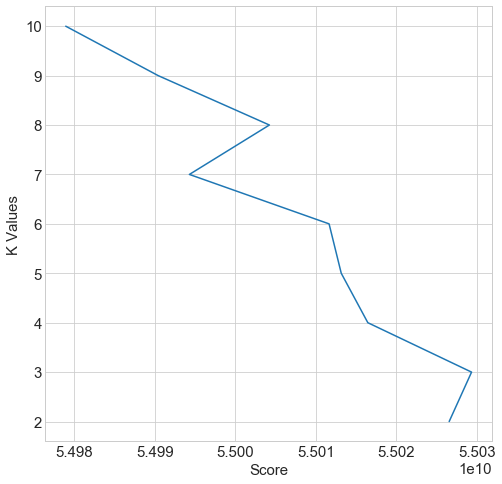

In [21]:
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(8,8))
plt.plot(scores,k)
plt.rcParams.update({'font.size': 15})

plt.xlabel('Score')
plt.ylabel('K Values')
plt.show()

In [8]:
model=KMeans(n_clusters=3)

In [9]:
model.fit(standardized_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

In [13]:
all_features = count_vect.get_feature_names()

In [16]:
from collections import Counter
from wordcloud import WordCloud

Cluster 0:


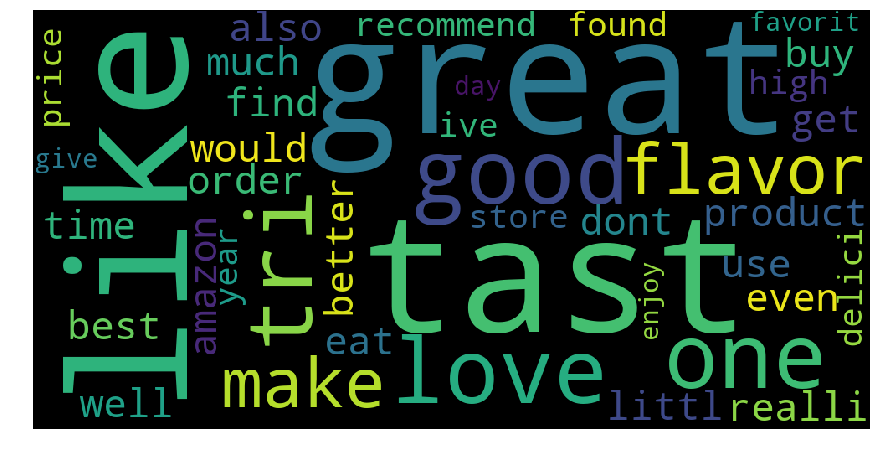

Cluster 1:


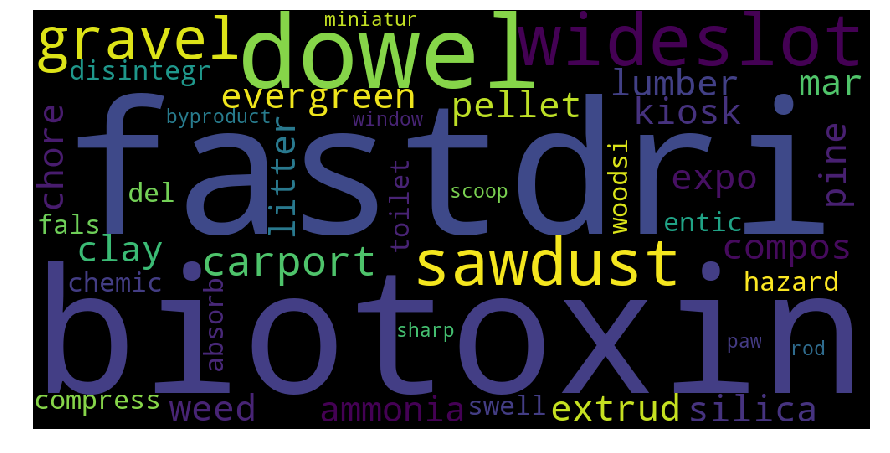

Cluster 2:


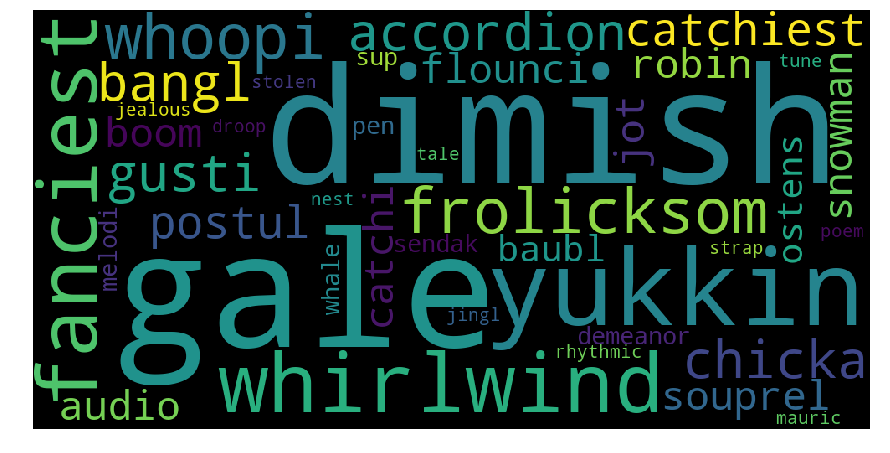

In [17]:
for i in range(optimal_k):
    top_feature_per_cluster=[]
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :40]:
        top_feature_per_cluster.append(all_features[ind])
    word_could_dict=Counter(top_feature_per_cluster)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.show()    

### tf-idf Vectorization Technique

In [19]:
tf_idf_vect = TfidfVectorizer()
X = tf_idf_vect.fit_transform(X)

In [20]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False)
standardized_X=standardized_data.fit_transform(X)

In [21]:
k=[2,3,4,5,6,7,8,9,10]
scores = []    
for i in k:
    
    kmeans = KMeans(n_clusters=i)

    # fitting the model 
    kmeans.fit(standardized_X)
    
    score=kmeans.inertia_

    scores.append(score)

In [22]:
optimal_k = k[scores.index(max(scores))]
print('\nThe optimal value is %d.' % optimal_k)


The optimal value is 4.


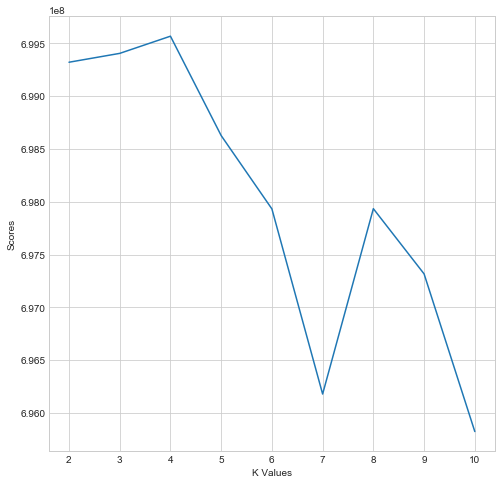

In [23]:
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(8,8))
plt.plot(k,scores)
plt.rcParams.update({'font.size': 15})

plt.xlabel('K Values')
plt.ylabel('Scores')
plt.show()

In [24]:
model=KMeans(n_clusters=4)

In [25]:
model.fit(standardized_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [26]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

In [27]:
all_features = tf_idf_vect.get_feature_names()

Cluster 0:


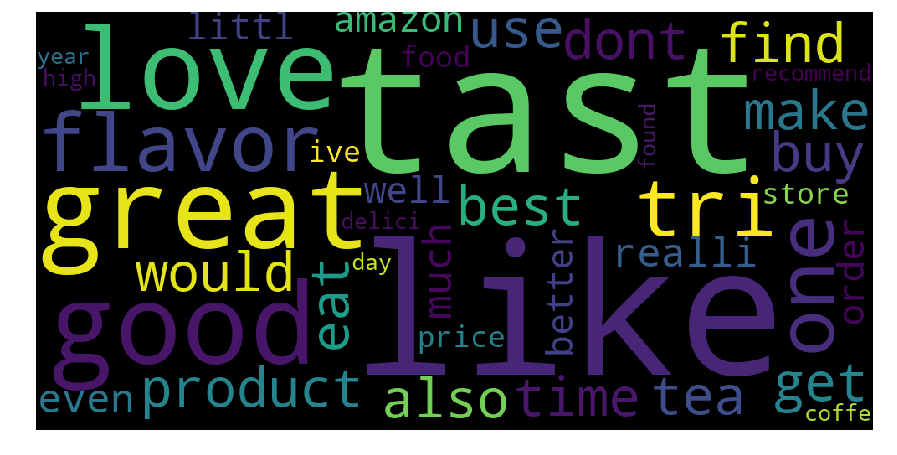

Cluster 1:


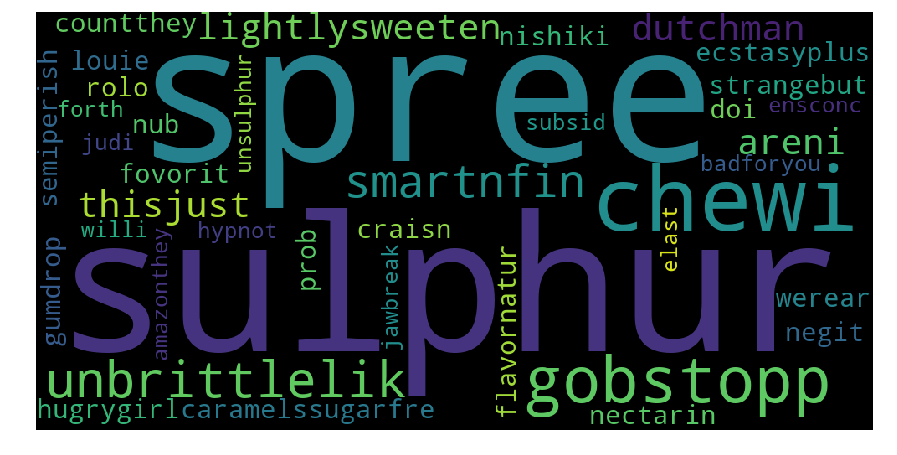

Cluster 2:


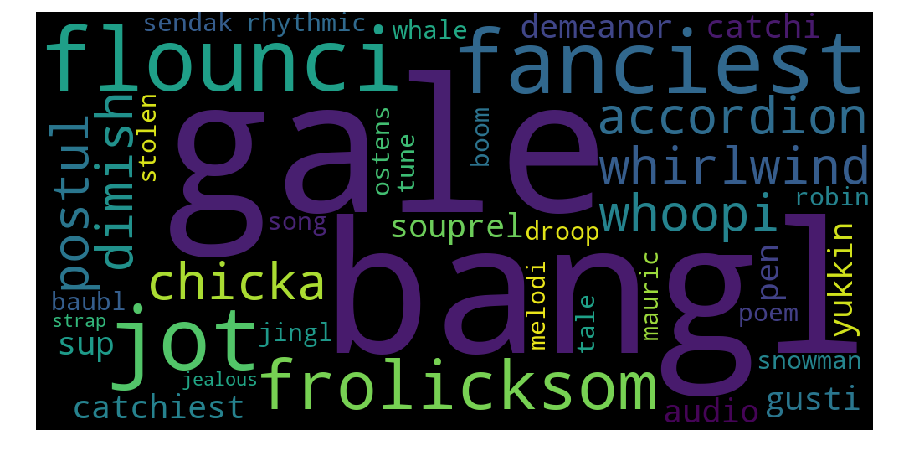

Cluster 3:


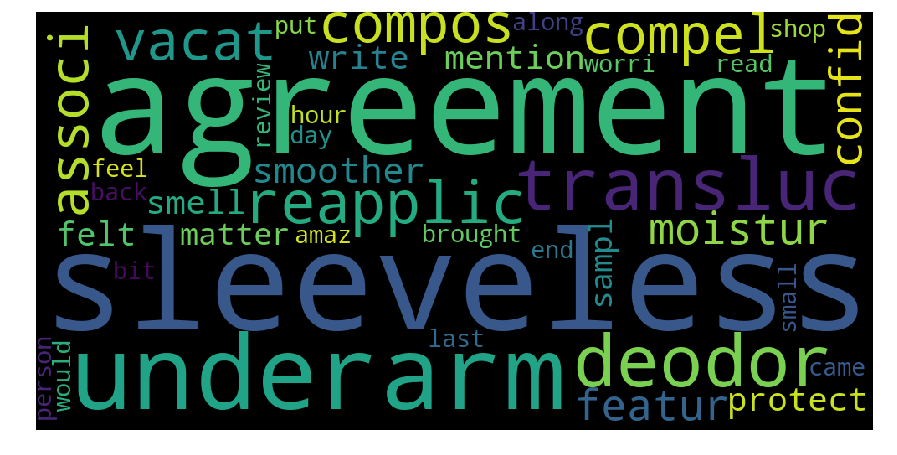

In [28]:
for i in range(optimal_k):
    top_feature_per_cluster=[]
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :40]:
        top_feature_per_cluster.append(all_features[ind])
    word_could_dict=Counter(top_feature_per_cluster)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.show() 

### W2V Vectorization Technique

In [9]:
# Train your own Word2Vec model using your own train corpus
import gensim


list_of_sent=[]
    
for sent in X:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [10]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [11]:
w2v = list(w2v_model.wv.vocab)

In [12]:
print("number of words that occured minimum 5 times ",len(w2v))

number of words that occured minimum 5 times  7127


In [40]:
print(w2v[:10])

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along']


### Average W2V

In [34]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X.values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:55<00:00, 449.17it/s]


25000
50


In [42]:
X=sent_vectors

In [43]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False)
standardized_X=standardized_data.fit_transform(X)

In [44]:
k=[2,3,4,5,6,7,8,9,10]
scores = []    
for i in k:
    
    kmeans = KMeans(n_clusters=i)

    # fitting the model 
    kmeans.fit(standardized_X)
    
    score=kmeans.inertia_

    scores.append(score)

In [45]:
optimal_k = k[scores.index(max(scores))]
print('\nThe optimal value is %d.' % optimal_k)


The optimal value is 2.


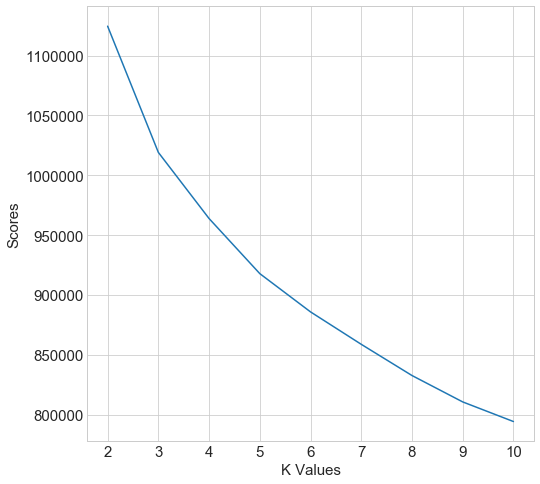

In [46]:
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(8,8))
plt.plot(k,scores)
plt.rcParams.update({'font.size': 15})

plt.xlabel('K Values')
plt.ylabel('Scores')
plt.show()

### tf-idf W2V Vectorization Technique

In [6]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [13]:
# TF-IDF weighted Word2Vec
from tqdm import tqdm
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X.values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:02<00:00, 399.37it/s]


In [14]:
X = tfidf_sent_vectors

In [15]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False)
standardized_X=standardized_data.fit_transform(X)

In [16]:
k=[2,3,4,5,6,7,8,9,10]
scores = []    
for i in k:
    
    kmeans = KMeans(n_clusters=i)

    # fitting the model 
    kmeans.fit(standardized_X)
    
    score=kmeans.inertia_

    scores.append(score)

In [17]:
optimal_k = k[scores.index(max(scores))]
print('\nThe optimal value is %d.' % optimal_k)


The optimal value is 2.


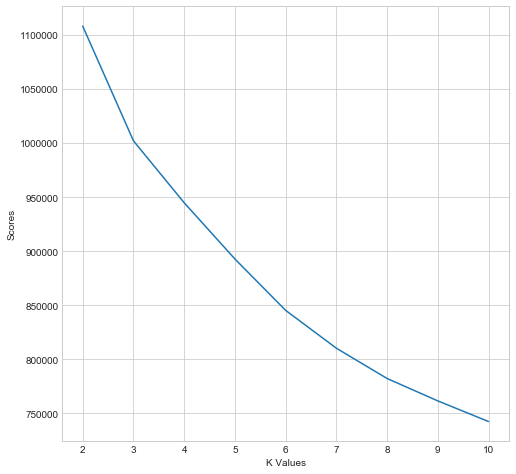

In [18]:
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(8,8))
plt.plot(k,scores)
plt.rcParams.update({'font.size': 15})

plt.xlabel('K Values')
plt.ylabel('Scores')
plt.show()

## Agglomerative Clustering

In [28]:
final=final.iloc[:2000,:]

In [123]:
X = final["CleanedText"]

In [30]:
from sklearn.cluster import AgglomerativeClustering

### Bag of Words (BoW) Vectorization Technique

In [86]:
count_vect = CountVectorizer() #in scikit-learn
X = count_vect.fit_transform(X)

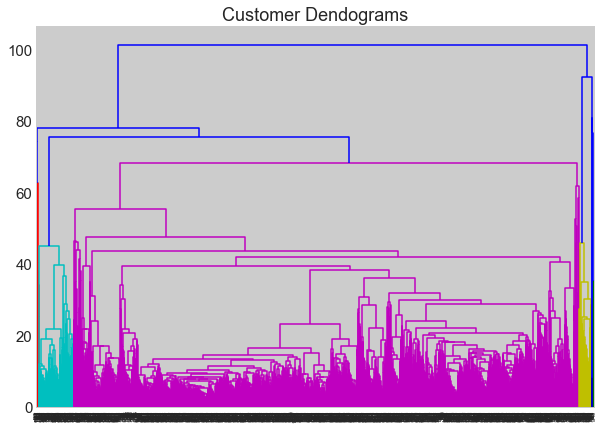

In [56]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(X.toarray(), method='ward'))
plt.show()


In [58]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit(X.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x00000239E41721E0>)

In [63]:
pred=cluster.labels_

In [69]:
X = pd.DataFrame(X.toarray()) 

In [70]:
X['Cluster'] = pred  # Add column corresponding to cluster number
word_frequencies_by_cluster = X.groupby('Cluster').sum()

In [87]:
all_features = count_vect.get_feature_names()

Cluster 0:


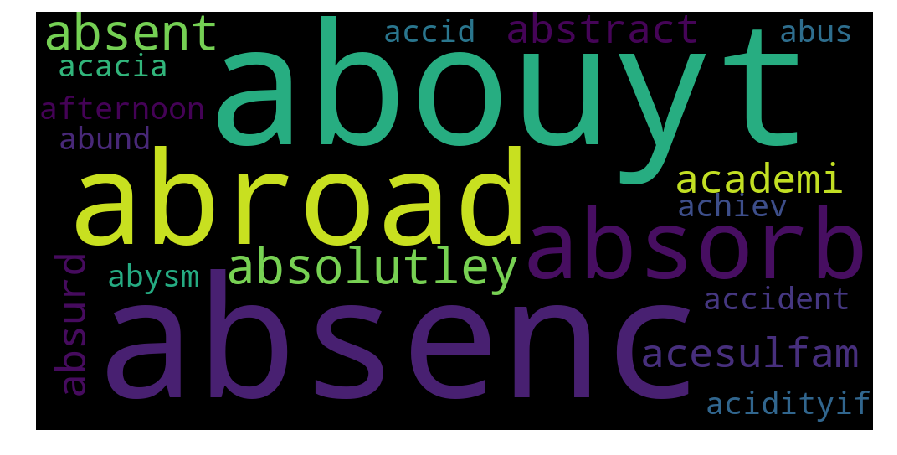

Cluster 1:


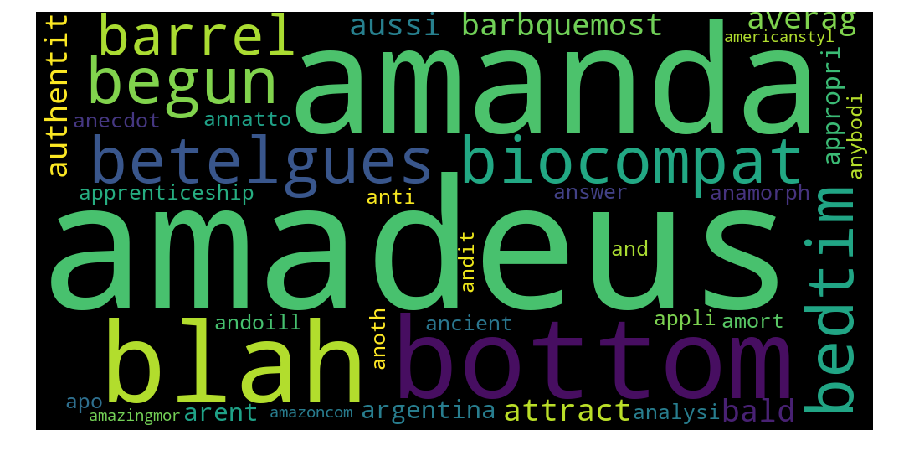

Cluster 2:


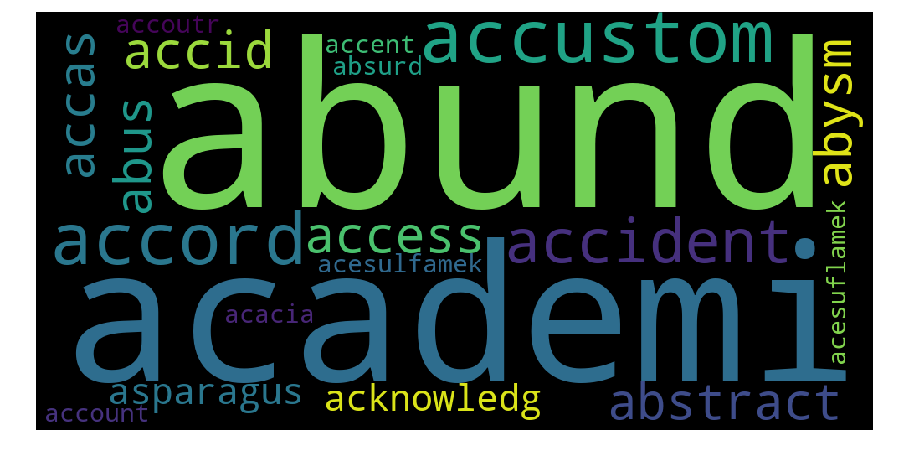

In [100]:
for i in range(3):
    top_feature_per_cluster=[]
    print("Cluster %d:" % i)
    res=sorted(word_frequencies_by_cluster.loc[i, :],reverse=True)
    res=res[:40]
   
    for ind in res:
        top_feature_per_cluster.append(all_features[int(ind)])
    word_could_dict=Counter(top_feature_per_cluster)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.show()

### tf-idf Vectorization Technique

In [104]:
tf_idf_vect = TfidfVectorizer()
X = tf_idf_vect.fit_transform(X)

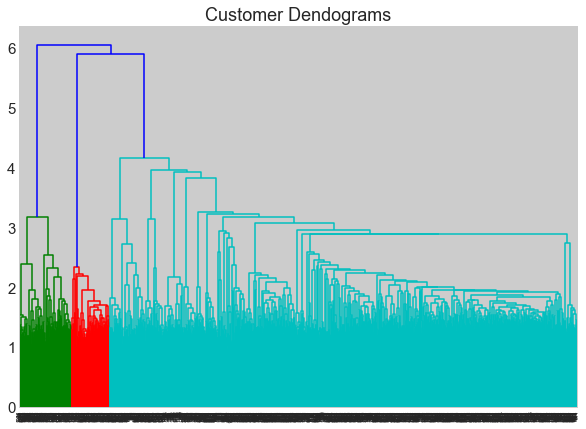

In [105]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(X.toarray(), method='ward'))
plt.show()

In [106]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit(X.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x00000239E41721E0>)

In [107]:
pred=cluster.labels_

In [108]:
X = pd.DataFrame(X.toarray()) 

In [109]:
X['Cluster'] = pred  # Add column corresponding to cluster number
word_frequencies_by_cluster = X.groupby('Cluster').sum()

In [110]:
all_features = tf_idf_vect.get_feature_names()

Cluster 0:


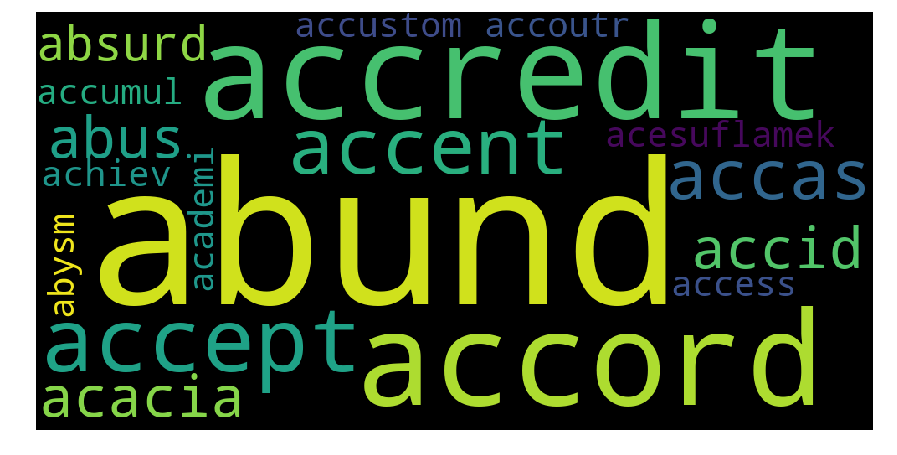

Cluster 1:


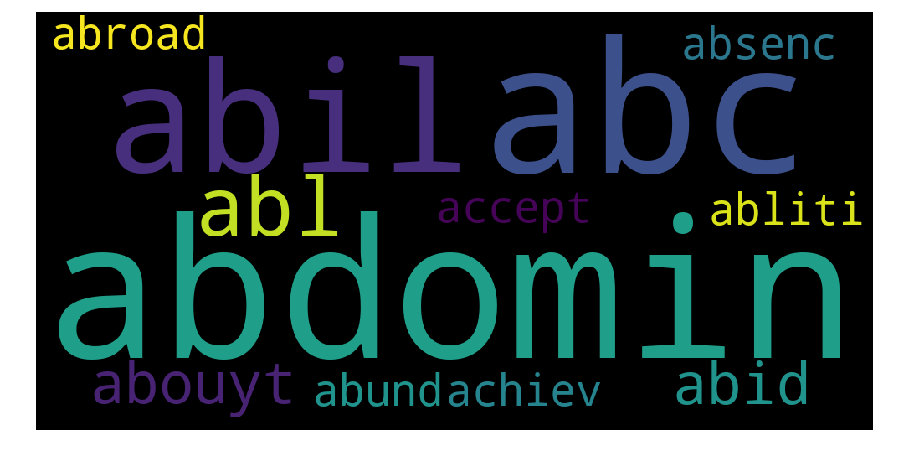

Cluster 2:


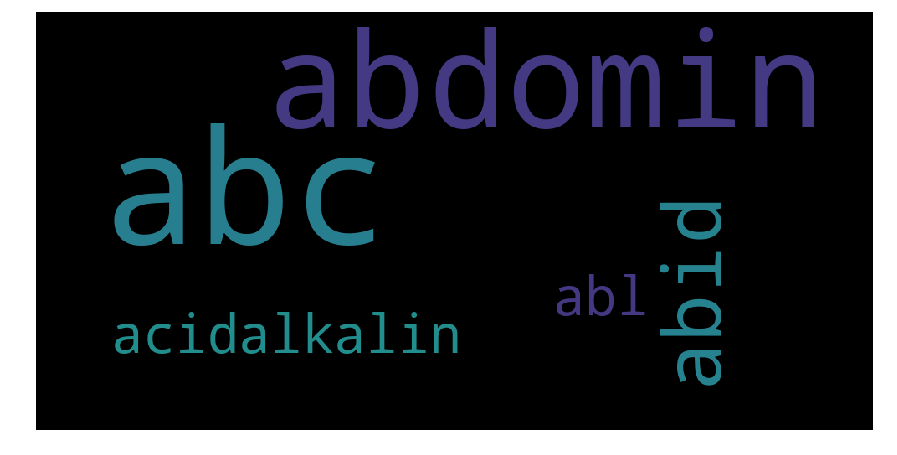

In [111]:
for i in range(3):
    top_feature_per_cluster=[]
    print("Cluster %d:" % i)
    res=sorted(word_frequencies_by_cluster.loc[i, :],reverse=True)
    res=res[:40]
   
    for ind in res:
        top_feature_per_cluster.append(all_features[int(ind)])
    word_could_dict=Counter(top_feature_per_cluster)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.show()

### W2V Vectorization Technique

In [ ]:
# Train your own Word2Vec model using your own train corpus
import gensim


list_of_sent=[]
    
for sent in X:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [ ]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [ ]:
w2v = list(w2v_model.wv.vocab)

## Average W2V

In [116]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X.values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 475.56it/s]


In [117]:
X = tfidf_sent_vectors

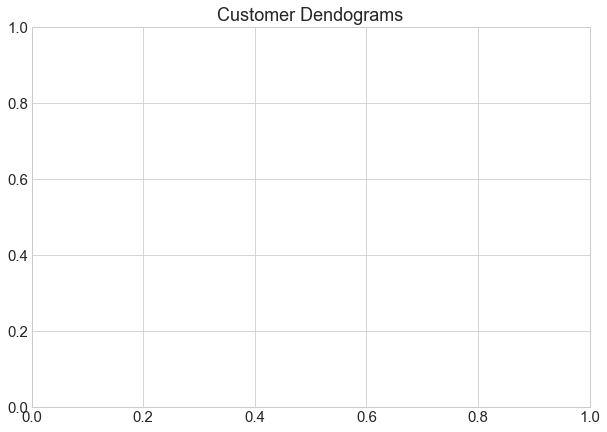

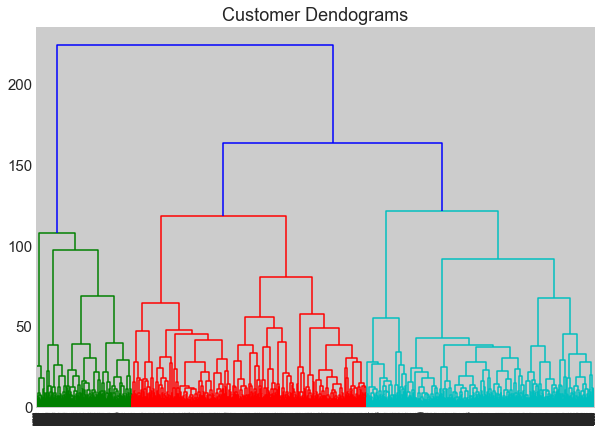

In [119]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.show()

In [121]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x00000239E41721E0>)

In [122]:
pred=cluster.labels_

In [125]:
a=pd.DataFrame(pred)

In [129]:
a.columns=['pred']

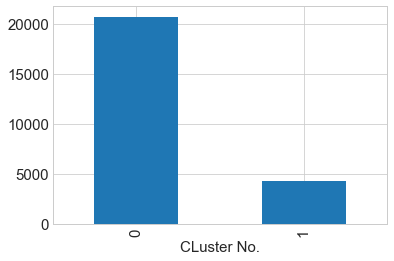

In [133]:
a['pred'].value_counts().plot.bar()
plt.xlabel('CLuster No.')
plt.show()

### tf-idf W2V Vectorization Technique

In [134]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [135]:
# TF-IDF weighted Word2Vec
from tqdm import tqdm
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X.values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 275.68it/s]


In [136]:
X = tfidf_sent_vectors

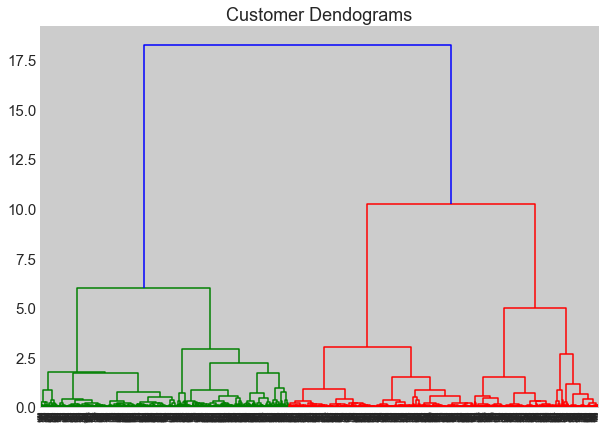

In [137]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.show()

In [138]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x00000239E41721E0>)

In [139]:
pred=cluster.labels_

In [140]:
a=pd.DataFrame(pred)

In [141]:
a.columns=['pred']

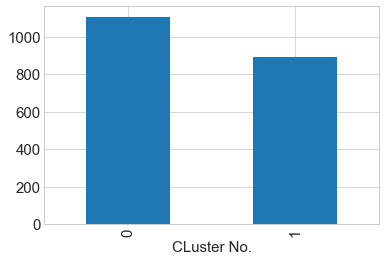

In [142]:
a['pred'].value_counts().plot.bar()
plt.xlabel('CLuster No.')
plt.show()

## DBSCAN Clustering

### W2V Vectorization Technique

In [6]:
# Train your own Word2Vec model using your own train corpus
import gensim


list_of_sent=[]
    
for sent in X:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [7]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [8]:
w2v = list(w2v_model.wv.vocab)

## Average W2V

In [9]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X.values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:47<00:00, 525.20it/s]


In [10]:
X = sent_vectors

In [11]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=100).fit(X)
distances, indices = nbrs.kneighbors(X)

In [14]:
distanceDec = sorted(distances[:,99], reverse=False)

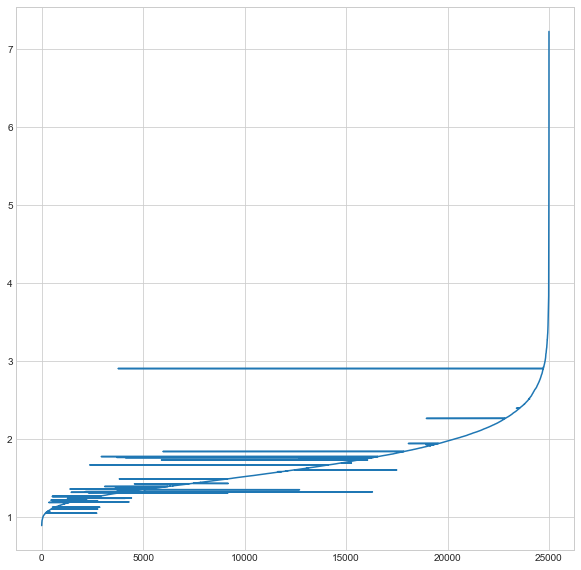

In [19]:
import seaborn as sns
sns.set_style("whitegrid")
plt.subplots(figsize=(10,10))
plt.plot(indices[:,0], distanceDec)
plt.show()

In [21]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=2.7, min_samples=100).fit(X)
pred=clustering.labels_

In [22]:
a=pd.DataFrame(pred)

In [23]:
a.columns=['pred']

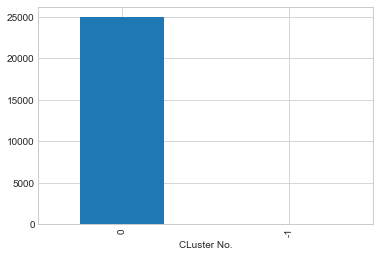

In [24]:
a['pred'].value_counts().plot.bar()
plt.xlabel('CLuster No.')
plt.show()

### tf-idf W2V Vectorization Technique

In [26]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [27]:
# TF-IDF weighted Word2Vec
from tqdm import tqdm
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X.values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:03<00:00, 393.02it/s]


In [28]:
X = tfidf_sent_vectors

In [29]:
nbrs = NearestNeighbors(n_neighbors=100).fit(X)
distances, indices = nbrs.kneighbors(X)

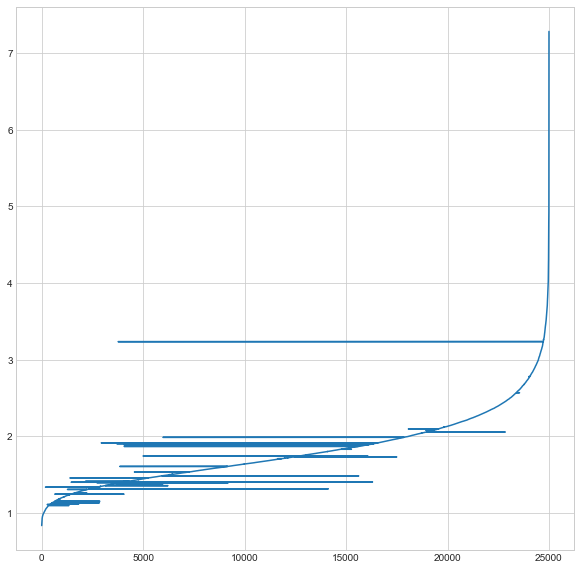

In [30]:
distanceDec = sorted(distances[:,99], reverse=False)
sns.set_style("whitegrid")
plt.subplots(figsize=(10,10))
plt.plot(indices[:,0], distanceDec)
plt.show()

In [31]:
clustering = DBSCAN(eps=2.9, min_samples=100).fit(X)
pred=clustering.labels_

In [32]:
a=pd.DataFrame(pred)

In [33]:
a.columns=['pred']

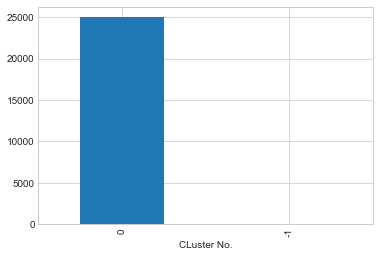

In [34]:
a['pred'].value_counts().plot.bar()
plt.xlabel('CLuster No.')
plt.show()

### Bag of Words (BoW) Vectorization Technique

In [76]:
count_vect = CountVectorizer(max_features=500) #in scikit-learn
X = count_vect.fit_transform(X)

In [7]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1000).fit(X)
distances, indices = nbrs.kneighbors(X)

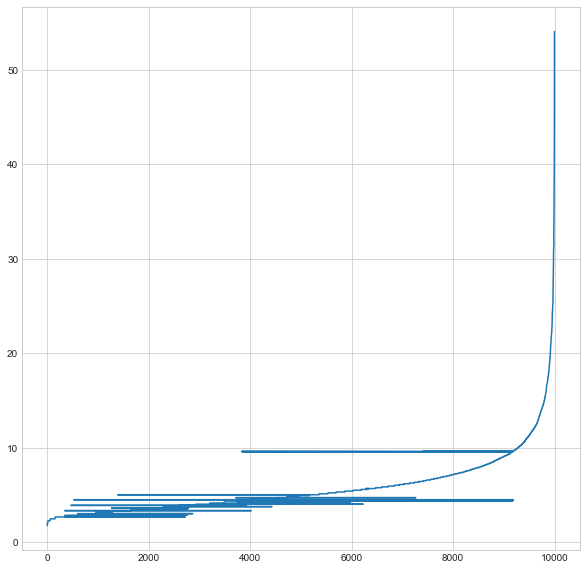

In [9]:
import seaborn as sns
distanceDec = sorted(distances[:,99], reverse=False)
sns.set_style("whitegrid")
plt.subplots(figsize=(10,10))
plt.plot(indices[:,0], distanceDec)
plt.show()

In [77]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=9.9, min_samples=1000).fit(X)
pred=clustering.labels_

In [78]:
X = pd.DataFrame(X.toarray()) 

In [79]:
X['Cluster'] = pred  # Add column corresponding to cluster number
noise_data=X[X['Cluster']== -1]
X=X-noise_data


In [14]:
all_features = count_vect.get_feature_names()

Cluster 0:


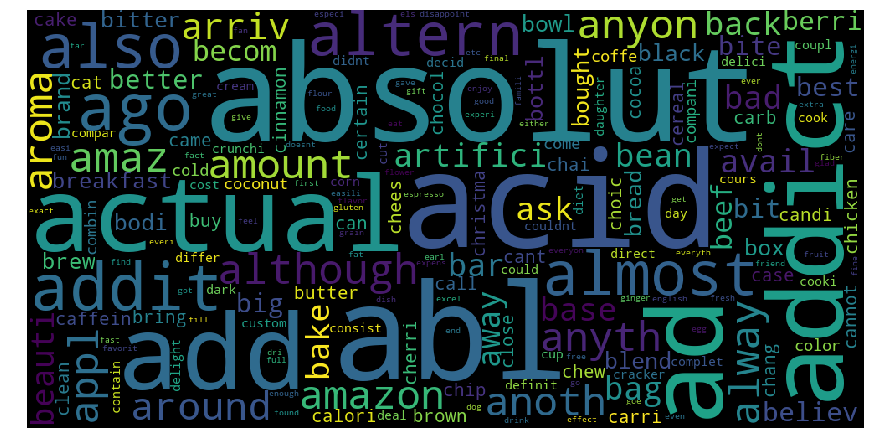

In [49]:
print("Cluster %d:" % 0)
top_feature_cluster=all_features[:500]

word_could_dict=Counter(top_feature_cluster)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()



### tf-idf Vectorization Technique

In [54]:
tf_idf_vect = TfidfVectorizer(max_features=500)
X = tf_idf_vect.fit_transform(X)

In [55]:
nbrs = NearestNeighbors(n_neighbors=1000).fit(X)
distances, indices = nbrs.kneighbors(X)

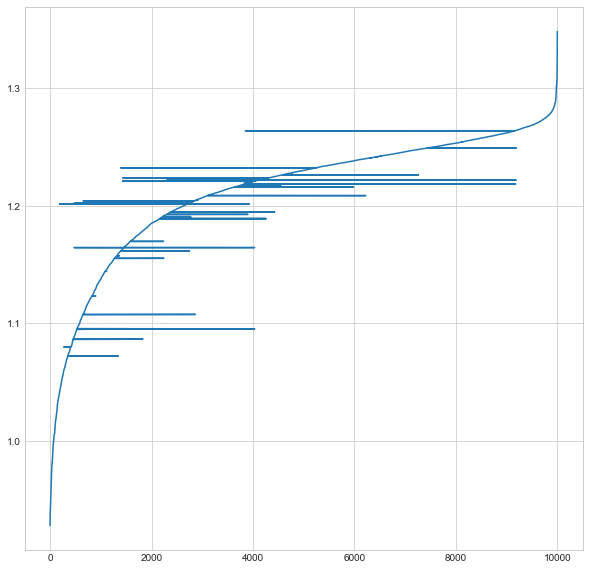

In [56]:
distanceDec = sorted(distances[:,99], reverse=False)
sns.set_style("whitegrid")
plt.subplots(figsize=(10,10))
plt.plot(indices[:,0], distanceDec)
plt.show()

In [57]:
clustering = DBSCAN(eps=12.8, min_samples=1000).fit(X)
pred=clustering.labels_

In [58]:
X = pd.DataFrame(X.toarray()) 

In [59]:
X['Cluster'] = pred  # Add column corresponding to cluster number
noise_data=X[X['Cluster']== -1]
X=X-noise_data


In [73]:
# create an array of feature names
feature_names = np.array(tf_idf_vect.get_feature_names())

# get order
idf_order = tf_idf_vect.idf_.argsort()[::-1]

# produce sorted idf word
feature_names=feature_names[idf_order][:100]

Cluster 0:


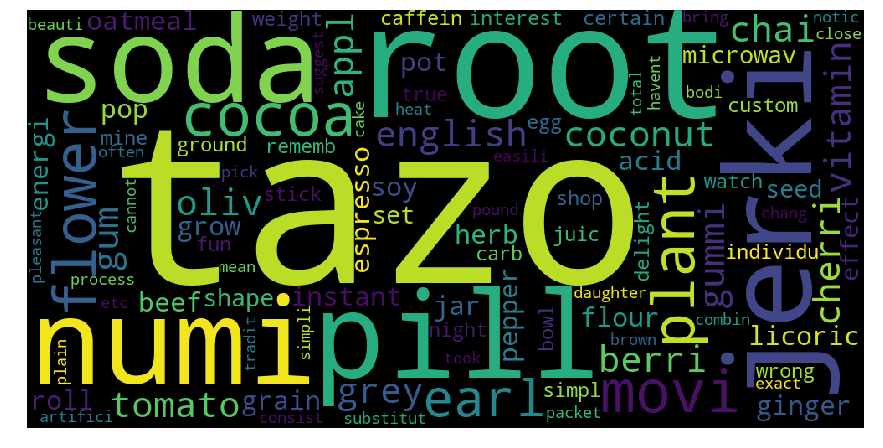

In [74]:
print("Cluster %d:" % 0)
top_feature_cluster=feature_names

word_could_dict=Counter(top_feature_cluster)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()
